In [109]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [110]:
data_path = "./data/"
label_file = "labels.csv"

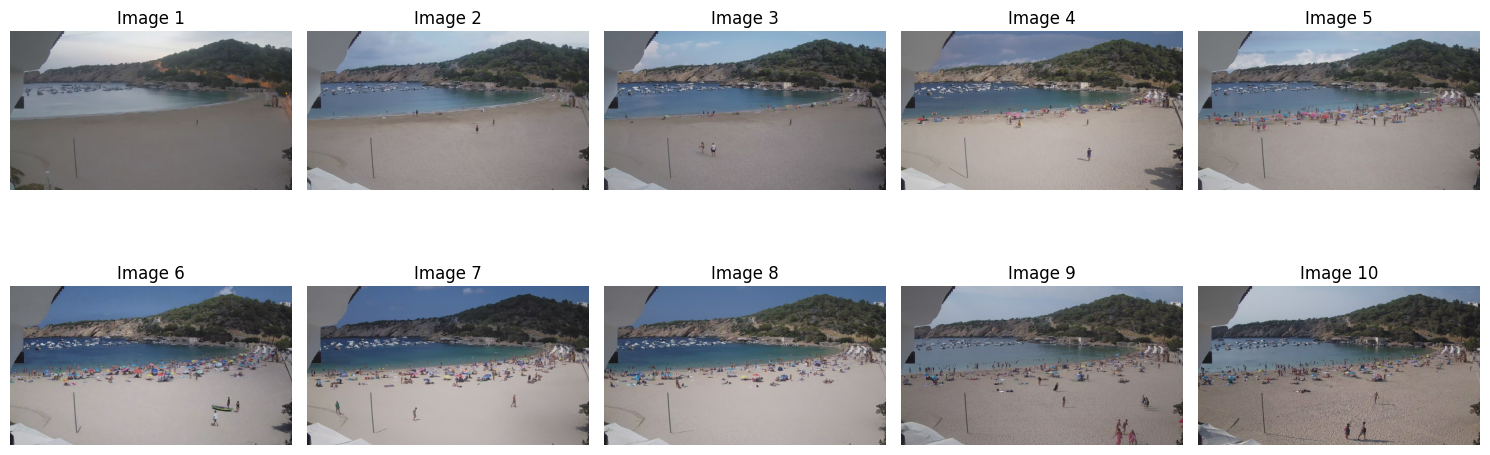

In [111]:
image_paths = [data_path + f'{i}.jpg' for i in range(0, 10)]

# Plot all images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    # Read image
    image_path = image_paths[i]
    image = cv2.imread(image_path)

    # Display the image
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [112]:
df = pd.read_csv(label_file)
df.head()

label     x    y image_name  size_x  size_y
0  Person  1157  654      1.jpg    1920    1080
1  Person   748  534      1.jpg    1920    1080
2  Person   723  541      1.jpg    1920    1080
3  Person  1061  504      1.jpg    1920    1080
4  Person   918  562      1.jpg    1920    1080

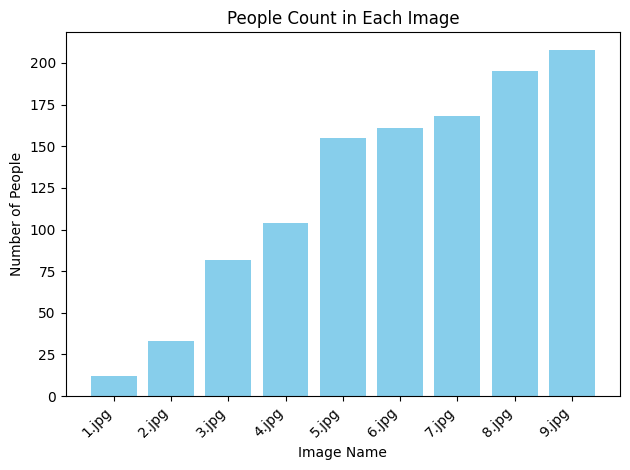

In [113]:
people_count = df.groupby('image_name')['label'].count()

# Plotting the bar chart
plt.bar(people_count.index, people_count.values, color='skyblue')
plt.xlabel('Image Name')
plt.ylabel('Number of People')
plt.title('People Count in Each Image')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [114]:
result = pd.DataFrame()

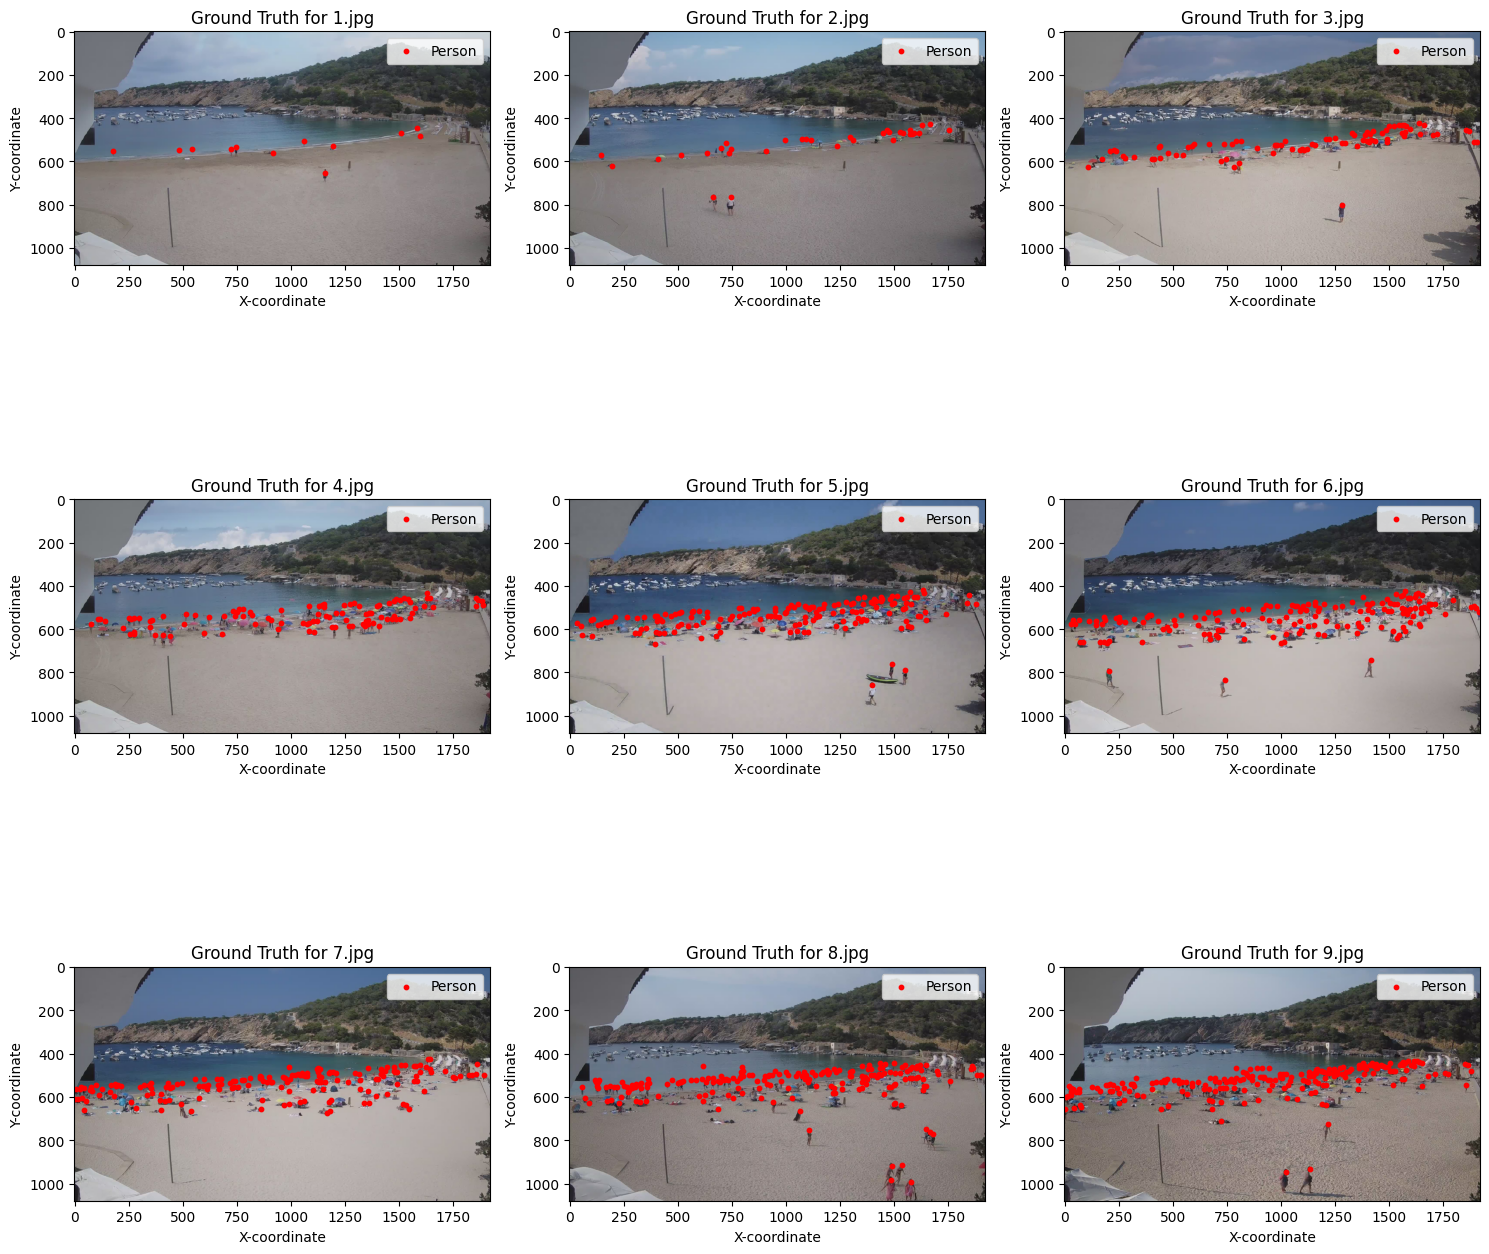

In [115]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
result['image'] = [f'{i}.jpg' for i in range(1, 10)]
ground_truths = []

# Loop through each image and draw points
for idx, image_name in enumerate(df['image_name'].unique()):
    image_data = df[df['image_name'] == image_name]
    ground_truths.append(len(image_data))

    image_path = data_path + image_name  # Replace with the actual path to your images
    image = cv2.imread(image_path)
    ax = axes[idx // 3, idx % 3]

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.scatter(image_data['x'], image_data['y'], color='red', marker='o', label='Person', s=10)

    ax.set_title(f'Ground Truth for {image_name}')
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.legend()

plt.tight_layout()
plt.show()

In [116]:
result['ground_truths'] = ground_truths

Let's write some function that will help to process image before detection.

In [117]:
def read_image(image_path):
    """
    Read an image from the given path.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
    return image

In [118]:
def convert_to_grayscale(image):
    """
    Convert an image to grayscale.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [119]:
def apply_background_subtraction(image, background):
    """
    Apply background subtraction to obtain a binary mask.
    """
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    blurred_background = cv2.GaussianBlur(background, (5, 5), 0)

    # Compute the absolute difference between the two blurred images
    diff = cv2.absdiff(blurred_background, blurred_image)

    # Threshold the difference image to obtain a binary mask
    _, thresholded = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

In [120]:
def find_people_contours(mask, min_contour_area=0, min_aspect_ratio=0.1):
    """
    Find contours in the binary mask and filter based on size and aspect ratio.
    Return a list of centroid coordinates for each detected person.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    people_centroids = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_contour_area and cv2.arcLength(cnt, True) > min_aspect_ratio * area:
            # Calculate centroid of the contour
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                people_centroids.append((cx, cy))

    return people_centroids

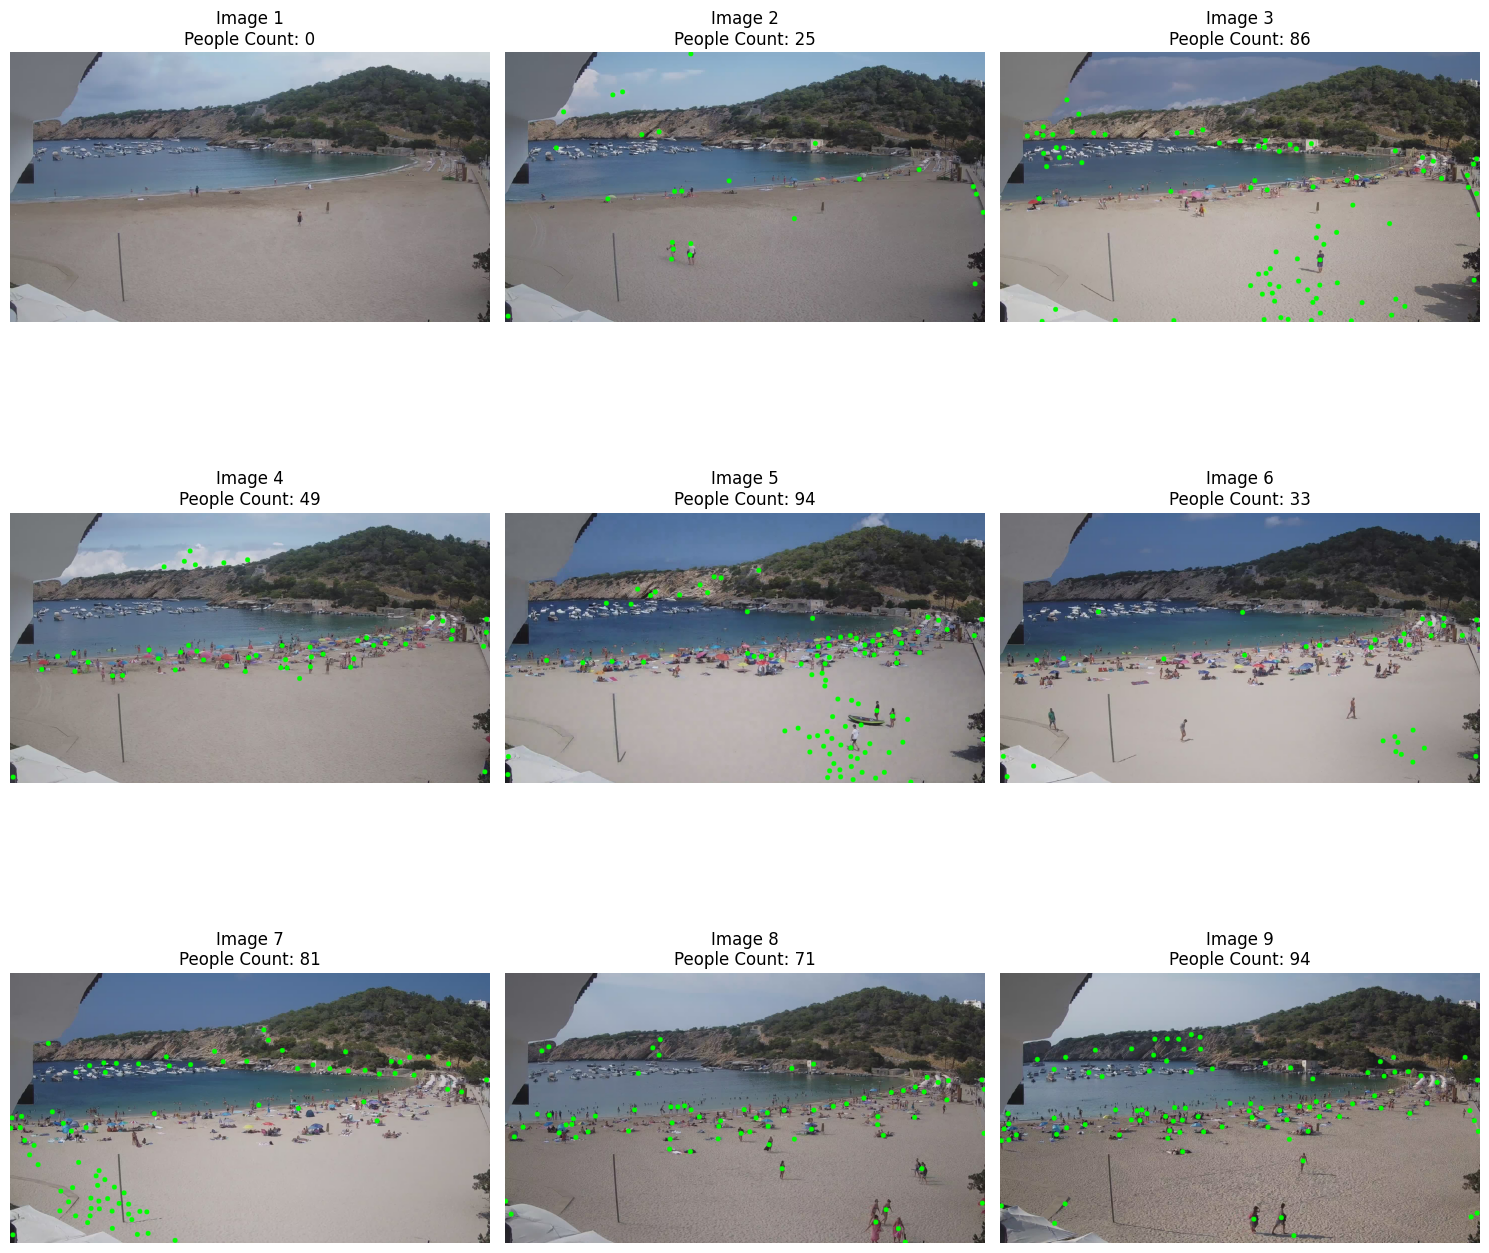

In [121]:
counts = []
all_people_centroids = []
image_paths = [data_path + f'{i}.jpg' for i in range(1, 10)]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    image_path = image_paths[i]
    background_path = image_paths[0]  # Assuming the background is the first image

    image = read_image(image_path)
    background = read_image(background_path)

    if image is not None and background is not None:
        # Convert images to grayscale
        gray_image = convert_to_grayscale(image)
        gray_background = convert_to_grayscale(background)

        # Apply background subtraction
        mask = apply_background_subtraction(gray_image, gray_background)

        # Find people centroids
        people_centroids = find_people_contours(mask)
        all_people_centroids.append(people_centroids)
        counts.append(len(people_centroids))

        # Draw centroids on the original image
        result_image = image.copy()
        for cx, cy in people_centroids:
            cv2.circle(result_image, (cx, cy), 10, (0, 255, 0), -1)

        # Display the result image
        ax.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Image {i+1}\nPeople Count: {len(people_centroids)}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [122]:
result['detected'] = counts
result

image  ground_truths  detected
0  1.jpg             12         0
1  2.jpg             33        25
2  3.jpg             82        86
3  4.jpg            104        49
4  5.jpg            155        94
5  6.jpg            161        33
6  7.jpg            168        81
7  8.jpg            195        71
8  9.jpg            208        94

In [123]:
result['mse'] = np.power(result['ground_truths'] - result['detected'], 2)
result

image  ground_truths  detected    mse
0  1.jpg             12         0    144
1  2.jpg             33        25     64
2  3.jpg             82        86     16
3  4.jpg            104        49   3025
4  5.jpg            155        94   3721
5  6.jpg            161        33  16384
6  7.jpg            168        81   7569
7  8.jpg            195        71  15376
8  9.jpg            208        94  12996

In [124]:
print(f"Mean MSE: {result['mse'].mean()}")

Mean MSE: 6588.333333333333


In [162]:
def calculate_distances(detected_positions, ground_truth_positions):
    distances = np.zeros((len(detected_positions), len(ground_truth_positions)))

    for i, det_pos in enumerate(detected_positions):
        for j, gt_pos in enumerate(ground_truth_positions):
            distances[i, j] = np.linalg.norm(np.array(det_pos) - np.array(gt_pos))

    return distances

In [163]:
def calculate_metrics(detected_positions, ground_truth_positions, distance_threshold):
    distances = calculate_distances(detected_positions, ground_truth_positions)

    # Initialize arrays to keep track of detection status
    detected_flags = np.zeros(len(detected_positions), dtype=bool)
    ground_truth_flags = np.zeros(len(ground_truth_positions), dtype=bool)

    # True positives (TP), False positives (FP), False negatives (FN)
    TP, FP, FN = 0, 0, 0

    for j in range(distances.shape[1]):
        min_distance_idx = np.argmin(distances[:, j])
        min_distance = distances[min_distance_idx, j]

        # If the minimum distance is less than the threshold, consider it a detection
        if min_distance < distance_threshold:
            detected_idx, ground_truth_idx = min_distance_idx, j

            # Check if the points have already been matched
            if not detected_flags[detected_idx] and not ground_truth_flags[ground_truth_idx]:
                TP += 1
                detected_flags[detected_idx] = True
                ground_truth_flags[ground_truth_idx] = True
            else:
                FP += 1

    # Calculate remaining unmatched ground truths as false negatives
    FN = np.sum(~ground_truth_flags)

    return TP, FP, FN


In [164]:
tps, fps, fns = [], [], []
images = [f'{i}.jpg' for i in range(1, 10)]

for index, image in enumerate(images):
    
    one_image = df[df['image_name'] == image]
    
    ground_truth_positions = list(zip(one_image['x'], one_image['y']))
    
    detected_positions = all_people_centroids[i]
    distance_threshold = 15
    
    TP, FP, FN = calculate_metrics(detected_positions, ground_truth_positions, distance_threshold)

    tps.append(TP)
    fps.append(FP)
    fns.append(FN)

In [165]:
result["TP"] = tps
result["FP"] = fps
result["FN"] = fns
result

image  ground_truths  detected    mse  TP  FP   FN  Precision    Recall
0  1.jpg             12         0    144   4   0    8   1.000000  0.333333
1  2.jpg             33        25     64   4   0   29   1.000000  0.121212
2  3.jpg             82        86     16   6   1   76   0.857143  0.073171
3  4.jpg            104        49   3025  10   3   94   0.769231  0.096154
4  5.jpg            155        94   3721  15   3  140   0.833333  0.096774
5  6.jpg            161        33  16384  13   3  148   0.812500  0.080745
6  7.jpg            168        81   7569  17   2  151   0.894737  0.101190
7  8.jpg            195        71  15376   9   2  186   0.818182  0.046154
8  9.jpg            208        94  12996  27   6  181   0.818182  0.129808

In [166]:
result['Precision'] = result['TP'] / (result['TP'] + result['FP']).replace(0, 1)
result['Recall'] = result['TP'] / (result['TP'] + result['FN']).replace(0, 1)
result

image  ground_truths  detected    mse  TP  FP   FN  Precision    Recall
0  1.jpg             12         0    144   4   0    8   1.000000  0.333333
1  2.jpg             33        25     64   4   0   29   1.000000  0.121212
2  3.jpg             82        86     16   6   1   76   0.857143  0.073171
3  4.jpg            104        49   3025  10   3   94   0.769231  0.096154
4  5.jpg            155        94   3721  15   3  140   0.833333  0.096774
5  6.jpg            161        33  16384  13   3  148   0.812500  0.080745
6  7.jpg            168        81   7569  17   2  151   0.894737  0.101190
7  8.jpg            195        71  15376   9   2  186   0.818182  0.046154
8  9.jpg            208        94  12996  27   6  181   0.818182  0.129808